In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn import cross_validation
import seaborn as sns

# Any results you write to the current directory are saved as output.

In [2]:
pd.options.display.max_columns = 999

In [3]:
train_data_ori = pd.read_csv('train.csv')
pd.options.display.max_rows = 999
train_data_ori.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data_ori = pd.read_csv('test.csv')

In [5]:
train_data = pd.concat([train_data_ori, test_data_ori]).reset_index(drop=True)

In [6]:
# Number of outcome classes
train_data['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

From the number of classess and their proportion, we can see that it is a binary classification problem with imbalanced category. Therefore, we need to consider using f1-score as the evalution metric

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
# Create function for extracting information from Name
import re
import string
def name_parsing(text):
    # Remove bracket content
    title = []
    middle_name = []
    last_name = []
    
    title_bank = ['Miss', 'Mr', 'Mrs', 'Dr', 'Master', 'Major', 'Rev', 'Capt', 'Lady',
       'Mme', 'Ms', 'Col', 'Mlle']
    
    for i in range(len(text)):
        # Remove the content in bracket
        text.iloc[i] = re.sub("[\(\[].*?[\)\]]", "", text.iloc[i])
        # Remove punctuation
        translation = text.iloc[i].maketrans("","", string.punctuation)
        # Split
        # ext_trans = text[i].translate(translation)
        text_split = text.iloc[i].split()
        lastname_flag = 0
        title_flag = 0
        for j in range(len(text_split)):
            if (',' in text_split[j]) & (lastname_flag == 0):
                last_name.append(text_split[j].translate(translation))
                last_name_flag = 1
            
            if ('.' in text_split[j]) & (title_flag == 0):
                title.append(text_split[j].translate(translation))                
                title_flag = 1                
    
        if last_name_flag == 0:
            last_name.append(np.nan)
        
        if title_flag == 0:
            title.append(np.nan)
            
        # first_name.append(text_split[-2].translate(translation))
        middle_name.append(text_split[-1].translate(translation))
        
    return pd.Series(title), pd.Series(last_name), pd.Series(middle_name)

In [9]:
# Map title name to represent better the gender and ages
title_map = {"Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"}

In [10]:
# Create function for name processing
def name_proc(data_frame, title_map):
    """
    Perfor processing on name column
    ------------------------------------
    Input: 
    name: Series containing name of the Passenger
    Output:
    One hot encoding of mapped titles using title_map
    """
    title, last, middle = name_parsing(data_frame['Name'])
    
    title = pd.Series(title)
    title = title.map(title_map)
    data_frame['title_name'] = title
    one_hot_title = pd.get_dummies(title, drop_first=True)
    
    data_frame.drop(labels='Name', axis=1, inplace=True)
    
    data_frame = data_frame.join(one_hot_title)
    
    return data_frame

In [11]:
train_data = name_proc(train_data, title_map)
#test_data = name_proc(test_data, title_map)

In [12]:
# Extract string and number information from ticket
def ticket_proc(data_frame):
    """
    Create columns with ticket letters and numbers
    ------------------------------------------------
    Input:
    Data frame with Ticket column
    Output:
    Data frame without Ticket column but with seperate letters and number informaiton
    """
    ticket_ori = data_frame['Ticket']

    ticket_num1 = []
    ticket_num2 = []
    ticket_str = []
    for tk in range(len(ticket_ori)):
        # Look for number in the string
        if len(re.findall(r'\d+', ticket_ori.iloc[tk])) ==0:
            ticket_num1.append(np.nan)
            ticket_num2.append(np.nan)
        else:
            ticket_num_temp = re.findall(r'\d+', ticket_ori.iloc[tk])
            if len(ticket_num_temp)>1:
                ticket_num1.append(np.int(ticket_num_temp[0]))
                ticket_num2.append(np.int(ticket_num_temp[-1]))
            else:
                ticket_num1.append(0)
                ticket_num2.append(np.int(ticket_num_temp[-1]))
        
        # Look for letters in the string
        if len(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))==0:
            ticket_str.append(np.nan)
        else:
            ticket_str.append(''.join(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk])))
        
    data_frame = data_frame.join([pd.Series(ticket_num1, name='ticket_num1'), pd.Series(ticket_num2, name='ticket_num2'), pd.Series(ticket_str, name='ticket_str')])
    data_frame.drop(labels='Ticket', axis=1, inplace=True)

    return data_frame

In [13]:
train_data = ticket_proc(train_data)
#test_data = ticket_proc(test_data)

In [14]:
train_data.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,ticket_str
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,Mr,0,1,0,0,0,5.0,21171.0,A
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,Mrs,0,0,1,0,0,0.0,17599.0,PC
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,Miss,1,0,0,0,0,2.0,3101282.0,STONO
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,Mrs,0,0,1,0,0,0.0,113803.0,NaN
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,Mr,0,1,0,0,0,0.0,373450.0,NaN


In [15]:
# Convert categorical to numerical values for Sex
def sex_proc(data_frame):
    data_frame.loc[:,'Sex'] = data_frame.loc[:,'Sex'].map({'male':0, 'female':1})
    return data_frame

In [16]:
train_data = sex_proc(train_data)
#test_data = sex_proc(test_data)

In [17]:
# Fill embarked with most most common case
# Use Dummy Variabe encoding
def embarked_proc(data_frame):
    data_frame.loc[:, 'Embarked'] = data_frame.loc[:, 'Embarked'].fillna(data_frame['Embarked'].value_counts().index[0])
    one_hot_embarked = pd.get_dummies(data_frame['Embarked'], drop_first=True, prefix='Embarked')
    
    data_frame = data_frame.join(one_hot_embarked)
    data_frame.drop(labels='Embarked', axis=1, inplace=True)
    
    return data_frame

In [18]:
train_data = embarked_proc(train_data)
#test_data = embarked_proc(test_data)

In [19]:
train_data.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,ticket_str,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,0,1,3,0,1,0.0,Mr,0,1,0,0,0,5.0,21171.0,A,0,1
1,38.0,C85,71.2833,0,2,1,1,1,1.0,Mrs,0,0,1,0,0,0.0,17599.0,PC,0,0
2,26.0,NaN,7.9250,0,3,3,1,0,1.0,Miss,1,0,0,0,0,2.0,3101282.0,STONO,0,1
3,35.0,C123,53.1000,0,4,1,1,1,1.0,Mrs,0,0,1,0,0,0.0,113803.0,NaN,0,1
4,35.0,NaN,8.0500,0,5,3,0,0,0.0,Mr,0,1,0,0,0,0.0,373450.0,NaN,0,1


We performed exploratory analysis and see that for groups with the same cabin number, they are either one family or combined family. However, it is possible that the ones with 'Cabin' could tell us the location. So we will use the Letter.

In [20]:
def Cabin_proc(data_frame):
    cabin = data_frame['Cabin']
    
    cabin_let = []
    for i in range(len(cabin)):
        if cabin[i] is not np.nan:
            if len(re.findall("[a-zA-Z]+", cabin[i])) !=0:
                cabin_let.append(re.findall("[a-zA-Z]+", cabin[i])[0])
        else:
            cabin_let.append('Z')        # The original Cabin index does not have 'Z', we assgin 'Z' to represent nan         
    
    cabin_let = pd.Series(cabin_let, name='cabin_let')
    one_hot_cabin = pd.get_dummies(cabin_let, prefix='Cabin', drop_first=True)
    data_frame = data_frame.join(one_hot_cabin)
    data_frame.drop(labels='Cabin', axis=1, inplace=True)
            
    return data_frame

In [21]:
train_data = Cabin_proc(train_data)
#test_data = Cabin_proc(test_data)

In [22]:
# Keep only the major ticket numbers
def ticket_str_proc(data_frame):
    ticket_str_tmp = data_frame['ticket_str'].value_counts()
    
    for i in range(6,len(ticket_str_tmp)):
        data_frame.loc[data_frame['ticket_str']==ticket_str_tmp.index[i], 'ticket_str'] = np.nan
    
    data_frame.loc[:,'ticket_str'] = data_frame.loc[:,'ticket_str'].fillna('Nostr')
    
    one_hot_ticket_str = pd.get_dummies(data_frame['ticket_str'], prefix='ticket', drop_first=True)
    data_frame = data_frame.join(one_hot_ticket_str)
    data_frame.drop(labels='ticket_str', axis=1, inplace=True)
    
    return data_frame

In [23]:
train_data = ticket_str_proc(train_data)
#test_data = ticket_str_proc(test_data)

In [24]:
def fill_na_fare_age(data_frame):
    
    # Treat 0 fare as nan
    data_frame.loc[data_frame['Fare']<0.0001, 'Fare'] = np.nan
    
    # fill the nan values in Age and Fare
    data_frame["Age"] = data_frame.groupby(['Sex','Pclass','title_name'])['Age'].transform(lambda x: x.fillna(x.median()))
    data_frame["Fare"] = data_frame.groupby(['Sex','Pclass','title_name'])['Fare'].transform(lambda x: x.fillna(x.median()))
    
    return data_frame

In [25]:
train_data = fill_na_fare_age(train_data)
#test_data = fill_na_fare_age(test_data)

In [26]:
train_data['ticket_num2'].value_counts().head()

2343.0     11
1601.0      8
2144.0      8
14879.0     7
17608.0     7
Name: ticket_num2, dtype: int64

In [27]:
train_data[train_data['ticket_num2'] == 1601.0]

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC
74,32.0,56.4958,0,75,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
169,28.0,56.4958,0,170,3,0,0,0.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
509,26.0,56.4958,0,510,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
643,26.0,56.4958,0,644,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
692,26.0,56.4958,0,693,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
826,26.0,56.4958,0,827,3,0,0,0.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
838,32.0,56.4958,0,839,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
930,26.0,56.4958,0,931,3,0,0,NaN,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [28]:
# Find the number of occurance for each ticket_num2
def add_occurance(data_frame):
    value_occ = pd.Series(data_frame['ticket_num2'].value_counts())
    value_occ_single = []
    for i in range(len(data_frame)):
        value_occ_tmp = data_frame.iloc[i]['ticket_num2']
        if np.isnan(value_occ_tmp):
            value_occ_single.append(1)
        else:
            # Confirm whether fare are shared across passengers with the same ticket number
            fare_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp, 'Fare']

            if len(fare_tmp.value_counts()) == 1:
                value_occ_single.append(value_occ[value_occ_tmp])
            else:
                value_occ_single.append(1)
                
    data_frame = data_frame.join(pd.Series(value_occ_single, name='occurance'), how='outer')
    
    return data_frame

In [29]:
train_data = add_occurance(train_data)
#test_data = add_occurance(test_data)

In [30]:
singleton = train_data[train_data['occurance']==1]

Median_ratio(15):nan
Median_ratio(15):nan
Median_ratio(15):1.0864549327726443


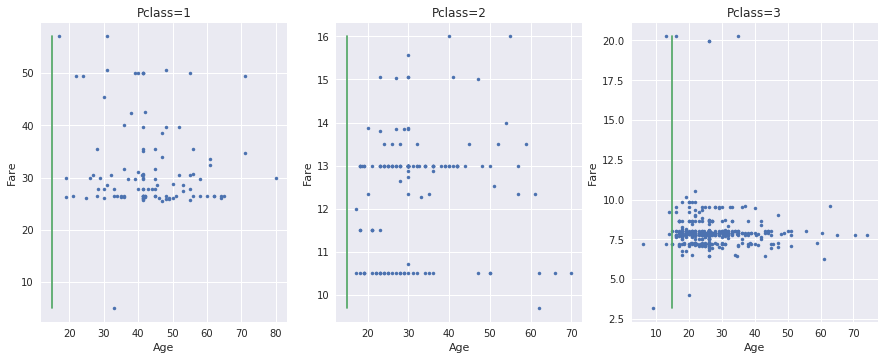

In [31]:
# For each Pclass, plot the relationship between Age and Fare for singleton
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
for i in range(3):
    singleton = train_data[(train_data['occurance'] == 1)&(train_data['Pclass'] == i+1)]
    median_ratio_15 = singleton.loc[singleton['Age']>15, 'Fare'].median()/singleton.loc[singleton['Age']<=15, 'Fare'].median()
    print('Median_ratio(15):{a}'.format(a=median_ratio_15))
    ax[i].plot(singleton['Age'], singleton['Fare'],'.')
    ax[i].plot(np.ones(10) * 15, np.linspace(singleton['Fare'].min(), singleton['Fare'].max(), 10))
    ax[i].set_title('Pclass={a}'.format(a=i+1))
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Fare')

In [32]:
# Obtain the final fare for dividing the number of occurence
def update_fare(data_frame):
    value_occ = pd.DataFrame(data_frame['ticket_num2'].value_counts())
    for i in range(len(value_occ)):
        value_occ_tmp = value_occ.iloc[i].name
        if ~np.isnan(value_occ_tmp):
            # Confirm whether fare are shared across passengers with the same ticket number
            fare_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp, 'Fare']
            data_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp]

            if len(fare_tmp.value_counts()) == 1:
                young_len = len(data_tmp[data_tmp['Age'] < 15])
                old_len = len(data_tmp[data_tmp['Age'] >= 15])
                data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] < 15), 'Fare'] = data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] <15), 'Fare'] / (old_len * 2 + young_len)
                data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] >= 15), 'Fare'] = data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] >=15), 'Fare'] / (old_len * 2 + young_len)*2
                
    return data_frame

In [33]:
train_data = update_fare(train_data)
#test_data = update_fare(test_data)

In [34]:
train_data[train_data['ticket_num2'] == 2343.0]

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance
159,6.0,3.4775,2,160,3,0,8,0.0,Master,0,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
180,18.0,6.9550,2,181,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
201,26.0,6.9550,2,202,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
324,26.0,6.9550,2,325,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
792,18.0,6.9550,2,793,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
846,26.0,6.9550,2,847,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
863,18.0,6.9550,2,864,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1079,18.0,6.9550,2,1080,3,1,8,NaN,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1233,26.0,6.9550,9,1234,3,0,1,NaN,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1251,14.5,3.4775,2,1252,3,0,8,NaN,Master,0,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 33 columns):
Age               1309 non-null float64
Fare              1309 non-null float64
Parch             1309 non-null int64
PassengerId       1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null int64
SibSp             1309 non-null int64
Survived          891 non-null float64
title_name        1308 non-null object
Miss              1309 non-null uint8
Mr                1309 non-null uint8
Mrs               1309 non-null uint8
Officer           1309 non-null uint8
Royalty           1309 non-null uint8
ticket_num1       1305 non-null float64
ticket_num2       1305 non-null float64
Embarked_Q        1309 non-null uint8
Embarked_S        1309 non-null uint8
Cabin_B           1309 non-null uint8
Cabin_C           1309 non-null uint8
Cabin_D           1309 non-null uint8
Cabin_E           1309 non-null uint8
Cabin_F           1309 non-null uint8
Cabin_G  

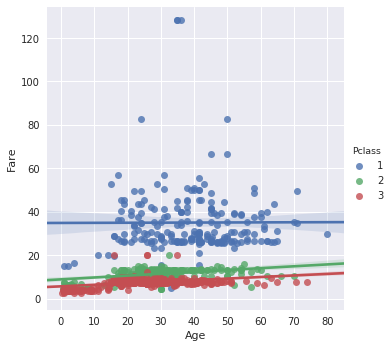

In [36]:
# Look into relationship between Age and Fare
sns.lmplot(x='Age', y='Fare', hue='Pclass', data=train_data[:892])

In [37]:
# sns.lmplot(x='Age', y='Fare', hue='Pclass', data=train_data[:892])

In [38]:
def drop_items(data_frame):
    data_frame.drop(labels='PassengerId', axis=1, inplace=True)
    data_frame.drop(labels='ticket_num2', axis=1, inplace=True)
    data_frame.drop(labels='title_name', axis=1, inplace=True)
    return data_frame

In [39]:
train_data = drop_items(train_data)
#test_data = drop_items(test_data)

In [40]:
train_data.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance
0,22.0,7.25000,0,3,0,1,0.0,0,1,0,0,0,5.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,38.0,35.64165,0,1,1,1,1.0,0,0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2
2,26.0,7.92500,0,3,1,0,1.0,1,0,0,0,0,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,35.0,26.55000,0,1,1,1,1.0,0,0,1,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2
4,35.0,8.05000,0,3,0,0,0.0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [41]:
def ticket_num1(data_frame):
    # Fill the nan in ticket_num1 and ticket_num2
    data_frame['ticket_num1'] = data_frame['ticket_num1'].fillna(0.0)
    one_hot_ticket_1 = pd.get_dummies(data_frame['ticket_num1'], prefix='ticket1', drop_first=True)
    
    data_frame = data_frame.join(one_hot_ticket_1)
    data_frame.drop(labels='ticket_num1', axis=1, inplace=True)
    
    return data_frame

In [42]:
train_data = ticket_num1(train_data)
#test_data = ticket_num1(test_data)

In [43]:
train_data.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Miss,Mr,Mrs,Officer,Royalty,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance,ticket1_2.0,ticket1_3.0,ticket1_4.0,ticket1_5.0
0,22.0,7.25000,0,3,0,1,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,38.0,35.64165,0,1,1,1,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0
2,26.0,7.92500,0,3,1,0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
3,35.0,26.55000,0,1,1,1,1.0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0
4,35.0,8.05000,0,3,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0


In [44]:
#test_data.head()

In [45]:
def Pclass_proc(data_frame):
    one_hot_Pclass = pd.get_dummies(data_frame['Pclass'], prefix='Pclass', drop_first=True)
    data_frame = data_frame.join(one_hot_Pclass)
    data_frame.drop('Pclass', axis=1, inplace=True)
    return data_frame

In [46]:
train_data = Pclass_proc(train_data)
# test_data = Pclass_proc(test_data)

In [47]:
def add_features(data_frame):
    data_frame['group_size'] = data_frame['Parch'] + data_frame['SibSp'] + 1
    data_frame['Singleton'] = data_frame['group_size'].map(lambda x: 1 if x == 1 else 0)
    data_frame['SmallFamily'] = data_frame['group_size'].map(lambda x: 1 if 1 < x <5 else 0)
    data_frame['LargeFamily'] = data_frame['group_size'].map(lambda x: 1 if x > 4 else 0)
    data_frame['Young'] = data_frame['Age'].map(lambda x: 1 if x <15 else 0)
    data_frame['Old'] = data_frame['Age'].map(lambda x: 1 if x > 45 else 0)
    
    return data_frame

In [48]:
train_data = add_features(train_data)

In [49]:
train_data_final = train_data.iloc[:891,:]
test_data_final = train_data.iloc[891:, :]

In [50]:
train_data_final.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Miss,Mr,Mrs,Officer,Royalty,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance,ticket1_2.0,ticket1_3.0,ticket1_4.0,ticket1_5.0,Pclass_2,Pclass_3,group_size,Singleton,SmallFamily,LargeFamily,Young,Old
0,22.0,7.25000,0,0,1,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,2,0,1,0,0,0
1,38.0,35.64165,0,1,1,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,2,0,1,0,0,0
2,26.0,7.92500,0,1,0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
3,35.0,26.55000,0,1,1,1.0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,2,0,1,0,0,0
4,35.0,8.05000,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0


In [51]:
train_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 40 columns):
Age               891 non-null float64
Fare              891 non-null float64
Parch             891 non-null int64
Sex               891 non-null int64
SibSp             891 non-null int64
Survived          891 non-null float64
Miss              891 non-null uint8
Mr                891 non-null uint8
Mrs               891 non-null uint8
Officer           891 non-null uint8
Royalty           891 non-null uint8
Embarked_Q        891 non-null uint8
Embarked_S        891 non-null uint8
Cabin_B           891 non-null uint8
Cabin_C           891 non-null uint8
Cabin_D           891 non-null uint8
Cabin_E           891 non-null uint8
Cabin_F           891 non-null uint8
Cabin_G           891 non-null uint8
Cabin_T           891 non-null uint8
Cabin_Z           891 non-null uint8
ticket_CA         891 non-null uint8
ticket_Nostr      891 non-null uint8
ticket_PC         891 non-null uint8
t

In [52]:
# Oversampling using SMOTE
# X_resampled, y_resampled = SMOTE().fit_sample(train_data_final, train_data_final['Survived'])
# X_train = pd.DataFrame(X_resampled.astype(int), columns=train_data_final.columns)
# print(sorted(Counter(y_resampled).items()))

For small sample size, I don't recommend using oversampling.

In [53]:
X_train = train_data_final
y_train = train_data_final['Survived']
X_test = test_data_final
X_test.drop('Survived', axis=1, inplace=True)
X_train.drop('Survived', axis=1, inplace=True)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

From the preliminary results with can see that even letting XGBboost to fill in nan by itself. The training error is still high. We therefore needs to perform error analysis.

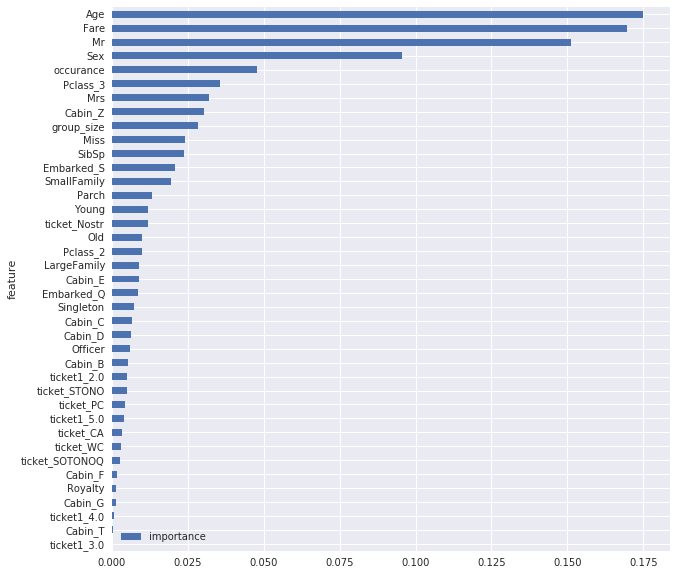

In [55]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(10, 10))

In [56]:
accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='accuracy', cv=5)
accuracies.mean()

0.82156588423168131

In [57]:
select_model = SelectFromModel(clf, prefit=True)
train_reduced = select_model.transform(X_train)
test_reduced = select_model.transform(X_test)
train_reduced.shape

(891, 9)

In [58]:
# Perform hyperparameter search for RandomForestClassifier
accuracies = cross_val_score(estimator=clf, X=train_reduced, y=y_train, scoring='accuracy', cv=5)
accuracies.mean()

0.82384460244692248

In [59]:
from sklearn.cross_validation import StratifiedKFold


parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [100, 80, 50],
             'max_features': ['sqrt', 'auto', 'log2'],
             'min_samples_split': [3, 10, 15],
             'min_samples_leaf': [1, 3],
             'bootstrap': [True, False],
             }
forest = RandomForestClassifier()
cross_validation = StratifiedKFold(y_train, n_folds=10)

grid_search = GridSearchCV(forest,
                           scoring='accuracy',
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_reduced, y_train)
rf_model = grid_search
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


Best score: 0.8406285072951739
Best parameters: {'min_samples_split': 3, 'bootstrap': True, 'n_estimators': 50, 'min_samples_leaf': 3, 'max_depth': 6, 'max_features': 'log2'}


In [60]:
# Refit with all the training data using best parameter
rf_final = RandomForestClassifier(**grid_search.best_params_)
rf_final.fit(train_reduced, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
# Obtain the accuracy
rf_predict_train = rf_final.predict(train_reduced)
print('accuracy={}'.format(accuracy_score(rf_predict_train, y_train)))

accuracy=0.867564534231201


In [62]:
test_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 39 columns):
Age               418 non-null float64
Fare              418 non-null float64
Parch             418 non-null int64
Sex               418 non-null int64
SibSp             418 non-null int64
Miss              418 non-null uint8
Mr                418 non-null uint8
Mrs               418 non-null uint8
Officer           418 non-null uint8
Royalty           418 non-null uint8
Embarked_Q        418 non-null uint8
Embarked_S        418 non-null uint8
Cabin_B           418 non-null uint8
Cabin_C           418 non-null uint8
Cabin_D           418 non-null uint8
Cabin_E           418 non-null uint8
Cabin_F           418 non-null uint8
Cabin_G           418 non-null uint8
Cabin_T           418 non-null uint8
Cabin_Z           418 non-null uint8
ticket_CA         418 non-null uint8
ticket_Nostr      418 non-null uint8
ticket_PC         418 non-null uint8
ticket_SOTONOQ    418 non-null uint8


In [63]:
# Predict on the test data
rf_predict_test = rf_final.predict(test_reduced)

In [64]:
# Save to working directory the correct format
output = pd.read_csv('output.csv')
output['Survived'] = rf_predict_test
output.to_csv('output.csv', index=False)

In [65]:
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = rf_predict_test
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

Obtain a test score of 0.779